# Constrained Parabolic Minimization

This notebook describes a function that, given a vector gradient and a matrix hessian that represent a parabolic approximation to a surface, finds the point that minimizes that surface, subject to the constraint that
its radius from the origin is $r <= r_0$

We have a surface with a quadratic cost function

$$
    J_0({\bf x}) = {\bf g} \cdot {\bf x} + \frac{1}{2} {\bf x}^T \cdot H \cdot {\bf x}
$$

(note that we deal with Hessians so H should be symmetric) and we want to find the ${\bf x}$ that minizimes $J$, subject to 

$$
    {\bf x}^T \cdot {\bf x} = r_0.
$$ 

where $r_0$ is a constant. We use the lagrange multiplier $\lambda$ to minimize

$$
    J({\bf x}) = \lambda {\bf x}^T \cdot {\bf x} + {\bf g} \cdot {\bf x} + \frac{1}{2} {\bf x}^T \cdot H \cdot {\bf x} \\
     = {\bf g} \cdot {\bf x} + \frac{1}{2} {\bf x}^T \cdot (H + \lambda I) \cdot {\bf x} 
$$


Given a value of $\lambda$, this is minimized at

$$
    {\bf x}_{min}(\lambda) = (H + \lambda I)^{-1} \cdot {\bf g}
$$

<br>

Thus we want to find the value of $\lambda$ that satisfies $ {\bf x}_{min}(\lambda)^T \cdot {\bf x}_{min}(\lambda) = r_0.$

The algorithm below first defines an internal cost function in a 1-dimensional space:

$$
Q(\lambda; r_0) = (|{\bf x}_{min}(\lambda)| - r_0)^2
$$

When $Q(\lambda) = 0$, we have found the $\lambda$ that satisfies the constraint. Thus we do a one-dimensional search over $\lambda$, which can be efficiently performed using Netwon's method. The algorithm below first scans over a grid of possible values of $\lambda$, to find initial values that get us close to satisfying the constraint. At each of these candidate values, the algorithm then runs a Newton's method search to try to get a precise value of $\lambda$ satisfying the constraint, and therefore minimizing the desired cost function $J$ subject to our constraint.

Note: if the ${\bf x}$ that would minimize $J$ subject to no constraints has a radius less than $r_0$, then we return that, effectively making the constraint $r <= r_0$, not just $r=r_0$.

<br>

Examples are below the function definition.


In [1]:
using ForwardDiff   # for the minimizations
using PyPlot        # for plotting examples

## First two helper functions, vgh() and one_d_minimizer()

In [2]:
#@include_me  constrained_parabolic_minimization.jl


include("gradient_utils.jl")


"""
function x, cost, iters_used, last_Delta_x = one_d_minimizer(seed, func; tol=1e-5, maxiter=100, start_eta=0.1)

Minimizes a 1-d function using constrained Hessian minimization. 
We don't trust the long-range info from the Hessian too much, meaning that there's
a given (adaptive) step size. If Newton's method suggests a step smaller than that step
size, we take it. Otherwise, we only move in the direction of the gradient by the stepsize.

Adaptive step size: Every step that the cost function gets smaller, the step grows by a factor 
of 1.1. If a step would have led to a larger cost function, the step is not taken, and
the size falls by a factor of 2.

PARAMETERS:
===========

seed       A float, the starting point for the minimization

func       A one dimensional function, takes a float and returns a float that represents the current cost.


OPTIONAL PARAMETERS:
====================

tol=1e-5   If a step would lead to a change in cost that is smaller in magnitude than tol, stop the minimization.

maxiter=100   Maximum number of iterations for the minimization

start_eta=0.1  The starting value of the step size


RETURNS:
========

x0     the value of x that minimizes f(x)

cost   The value of f(x0) 

niters  The number of iterations done

Dparam  The last change to the parameter value

"""
function one_d_minimizer(seed, func; tol=1e-5, maxiter=100, start_eta=0.1)
    eta = start_eta;
    lambdavec = [seed]


    cost, grad, hess = vgh(func, lambdavec)

    i = delta_lambda = 0;  # declare it so we can use it after the if
    for i in [1:maxiter;]
        h_delta = - grad./hess;
        if abs(h_delta[1]) < eta
            new_lambdavec = lambdavec + h_delta
        else
            new_lambdavec = lambdavec - eta*sign.(grad)
        end

        delta_lambda = new_lambdavec[1] - lambdavec[1]
        if abs(delta_lambda) < tol
            break
        end
        
        new_cost, new_grad, new_hess = vgh(func, new_lambdavec)

        if new_cost .< cost
            lambdavec[1] = new_lambdavec[1]
            cost = new_cost;
            grad = new_grad;
            hess = new_hess;

            eta = eta*1.1
        else
            eta = eta/2
        end

        # @printf "%d: cost=%.3f lambda=%.3f\n" i cost lambdavec[1]
    end
    
    return lambdavec[1], cost, i, delta_lambda
end
    


one_d_minimizer

## The main constrained_parabolic_minimization() function

In [3]:
#@include_me  constrained_parabolic_minimization.jl

"""
function x, J, lambdas, costs, niters, Dlambda = constrained_parabolic_minimization(H, G, r; tol=1e-6, 
    min_only=true, do_plot=false, 
    verbose=false, efactor=3.0, max_efactor_tries=10, 
    lambdastepsize=0.003, minimum_tol=1e-24, tol_delta=1e-3, maxiter=200)

Given a Hessian matrix, a gradient vector, and a desired radius from the origin, finds the vector 
that minimizes the parabola defined by the Hessian and the gradient, subject to the constraint that the
vector's length equals the desired radius.

# PARAMETERS:

- H      A square symmetric matrix. 

- G      A vector, length equal to the size(H,2)

- r      desired radius

# OPTIONAL PARAMETERS:

- tol=1e-6        Numerical tolerance on the computations

- min_only=true   Return only the minimum, or, if false, all xs for all lambdas that match x'*x = r^2 
                    (some of thos might be maxima, not minima)

- efactor=3       The initial exploration of lambdas will go from -efactor(max(absolute(eig(H)))) to +efactor(max(absolute(eig(H))))
                If that does not produce a solution within the indicates tolerance, then efactor is multiplied by efactor_growth
                and we try again, up to max_efactor_tries.

- efactor_growth  see efactor

- max_efactor_tries   see efactor

- minimum_tol     Each candidate value of lambda, identified as a minimum in the grid scan and 
                proposed as satisfying |x|^2=r^2, is then used to seed a Newton's method one-d minimization with a certain tolerance.
                If the results of that search do not satisfy |x|^2=r^2 within the desired tolerance, then the tolerance
                for the 1-d search is reduced (to make the one-d search more exact), by a factor of tol_delta, 
                up to minimum_tol

- tol_delta       see minimum_tol

- max_iter        Maximum number of iterations in the 1-d search (see minimum_tol).


- lambdastepsize=0.003    The step size for initial exploration of lambdas, un units of efactor. It sshould
                probably scale with the smallest difference in the eigenvalues of H; that has not been implemented yet.

- do_plot         If true, produces plot of the initial gridscans of lambda versus (x'*x - r^2)^2

- verbose         If true, produces diagnostic info as it goes.


RETURNS:
========

- x        The vector that minimizes 0.5*x'*H*x + x'*G subject to x'*x = r
 
- J        0.5*x'*H*x + x'*G at the returned x

- lambda   value of the Lagrange multiplier at which the radius constraint is satisfied

- c        The squared difference between the length of x and r. Should be small, otherwise somthing went wrong!

- niters   The number of iterations used in the one-d minimization that identified the output lambdas.

- Dlambda  The last change in lambda during the one-d minimization. If the one-d minimization did not reach
         its maxiters, then this will be smaller than the one-d minimization's tolerance.

"""
function constrained_parabolic_minimization(H, G, r; tol=1e-6, min_only=true, 
    do_plot=false, verbose=false, efactor=3.0, efactor_growth=4, max_efactor_tries=10, 
    lambdastepsize=0.003, minimum_tol=1e-24, tol_delta=1e-3, maxiter=200)

    #  --- First a couple of helper functions ----
    
    """
    function x_of_lambda(lambda)

    Given square matrix H, vector G, and passed scalar lambda, returns the vector x that minimizes
    
    0.5 x'*H*x + x'*G - lambda *x'*x

    """
    function x_of_lambda(lambda)
        return inv(H - lambda*eye(size(H,1)))*(-G)
    end
    
    
    """
    function q(lambda, r)

    Returns the squared difference between r and the norm of x_of_lambda(lambda).
    """
    function q(lambda, r)
        return (r - norm(x_of_lambda(lambda)))^2
    end


    # efactor is the factor that multiplies the biggest eigenvalue of H, to determine the range over which we'll
    # look for a lambda that satisfies the norm(x)==r requirement. If we don't find a solution, we iteratively 
    # increase efactor to try to get there, for a maximum of max_efactor_tries
    for m=1:max_efactor_tries
        # First scan lambda to find good candidates for minimizing the parabolic 
        # surface under the x'*x = r^2 constraint
        L = eig(H)[1]
        L0 = maximum(abs.(L))
        lambdas = L0*efactor*[-1.0:lambdastepsize:1.0;]
        costs = zeros(size(lambdas))
        for i in [1:length(lambdas);]
            try 
                costs[i] = q(lambdas[i], r)
            catch
                costs[i] = Inf
            end
        end

        if do_plot
            figure(2); clf();
            plot(lambdas, costs, "b.-")
            xlabel("lambda")
            ylabel("cost")
        end

        # Take all candidates where the derivative of costs changes sign 
        # from negative to positive (those would be minima),
        # plus the smallest and the largest lambdas tested, as candidates
        g = append!(prepend!(find(diff(sign.(diff(costs))) .> 0.99), [1]), [length(lambdas)])
        if verbose
            @printf("cpm: g (candidate indices) are : ");           print_vector_g(g);        print("\n")
            @printf("cpm: and their corresponding costs are : ");   print_vector(costs[g]);   print("\n");
            @printf("cpm: and their corresponding lambdas are : "); print_vector(lambdas[g]); print("\n");
            @printf("cpm: the minimum cost was : %g\n", minimum(costs[g]))
        end
        # found_it_flag = 0  # A flag for when we've found at least one lambda that satisfies the r constraint
        mytol = tol

        while mytol > minimum_tol
            lambdas_out = zeros(size(g))
            costs_out   = zeros(size(g))
            niters_out  = zeros(size(g))
            Dlambda_out = zeros(size(g))
            for i in [1:length(g);]
                lambdas_out[i], costs_out[i], niters_out[i], Dlambda_out[i] = 
                one_d_minimizer(lambdas[g[i]], x -> q(x[1], r), start_eta=1, tol=mytol, maxiter=maxiter)
            end

            # Eliminate any lambdas where x'*x doesn't match our desired value r
            I = find(costs_out .< tol)
            lambdas_out = lambdas_out[I]; costs_out = costs_out[I];
            niters_out  = niters_out[I];  Dlambda_out = Dlambda_out[I]

            if length(I) > 0; break; end

            mytol *= tol_delta
        end
        if verbose
            @printf("%d : After searching for lambdas with efactor=%g, we found these : ", m, efactor)
            print_vector_g(lambdas_out); print("\n")
        end
        if length(lambdas_out) > 0; break; end;
        efactor = efactor*efactor_growth
    end
    
    # Eliminate any repeated lambdas, to within the specified numerical tolerance.
    I = setdiff(1:length(lambdas_out), find(diff(lambdas_out) .< tol))
    lambdas_out = lambdas_out[I]; costs_out = costs_out[I];
    niters_out  = niters_out[I];  Dlambda_out = Dlambda_out[I]
    
    # Find the parabolic estimate of the cost function at these points
    J  = zeros(size(lambdas_out))
    xs = zeros(length(G), length(lambdas_out))
    for i in [1:length(J);]
        xs[:,i] = x_of_lambda(lambdas_out[i])
        J[i] = (0.5*xs[:,i]'*H*xs[:,i] + xs[:,i]'*G)[1]
    end

    # Find and return only the x that has the smallest J
    if min_only
        I = indmin(J)    
    else
        I = 1:length(J)
    end
    return xs[:,I], J[I], lambdas_out[I], costs_out[I], niters_out[I], Dlambda_out[I]
end



constrained_parabolic_minimization

## Examples

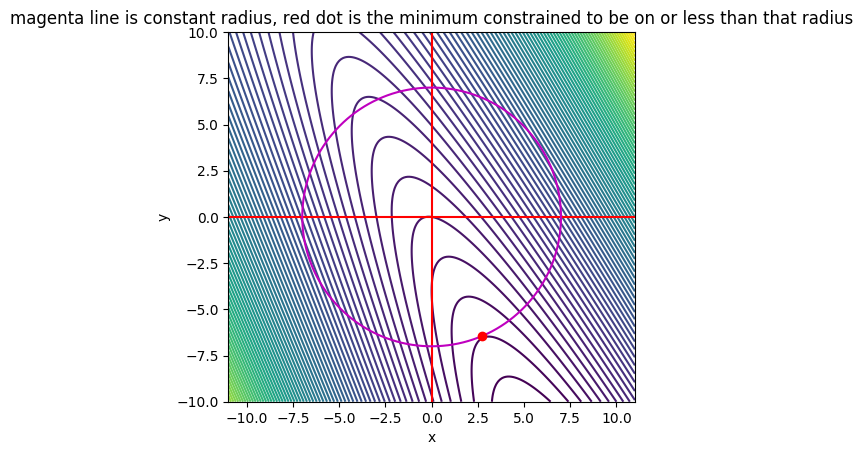

PyObject Text(0.5,1,'magenta line is constant radius, red dot is the minimum constrained to be on or less than that radius')

In [5]:
H = [2 1 ; 1 0.5]
g = [0.3, 2]
r0 = 7

p = constrained_parabolic_minimization(H, g, r0)[1]


xax = -11:0.1:11
yax = -10:0.1:10
X = repmat(xax', length(yax), 1)
Y = repmat(yax, 1, length(xax))

J = zeros(length(xax), length(yax))

func = (x) -> (g'*x + 0.5*x'*H*x)[1]

for xi=1:length(xax)
    for yi=1:length(yax)
        J[xi, yi] = func([xax[xi], yax[yi]])
    end
end


figure(1); 
contour(X, Y, J', 80)
vlines(0, ylim()[1], ylim()[2], "r")
hlines(0, xlim()[1], xlim()[2], "r")

theta = 0:0.01:(2*pi)
plot(r0*cos.(theta), r0*sin.(theta), "m-")
h = plot(p[1], p[2], "ro")
axis("scaled")
xlabel("x"); ylabel("y")
title("magenta line is constant radius, red dot is the minimum constrained to be on or less than that radius")


To double check that everything is working, we can look at the cost function on the radius at places close to the found minimum. In 2-d, it's easy, we know we're on a circle parametrized by an angle theta. Run the code below to see that adding or subtracting small amounts to theta leads to increases in the cost function.

In [6]:
theta = atan(p[2]/p[1])
func([r0*cos(theta), r0*sin(theta)])

e = -0.001
(func([r0*cos(theta+e), r0*sin(theta+e)]) - func([r0*cos(theta), r0*sin(theta)]))


6.682275222757994e-5